In [31]:
# !pip install xlrd
# !pip install pandas
# !pip install numpy
# !pip install scipy.stats
# !pip install seaborn
# !pip install matplotlib.pyplot
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import statsmodels.api as sm

In [172]:
file_path = 'C:/Users/knstrock/Desktop/JOB/ASBIS/Sample - APAC Superstore.xls'
xl = pd.ExcelFile(file_path, engine='xlrd')

# Вывод списка всех листов
sheet_names = xl.sheet_names

# Отображение
print("Available sheets:")
for i, sheet_name in enumerate(sheet_names):
    print(f"{i + 1}. {sheet_name}")

# Что будем загружать в дата сет для анализа?
#selected_sheets_indices = input("Через запятую какие sheets выводить: ")

# Преобразуем в индексы
#selected_sheets_indices = list(map(int, selected_sheets_indices.split(',')))
selected_sheets_indices = list(map(int, [1,2,3]))
# Загружаем в словарь DataFrames
dataframes = {}
for sheet_index in selected_sheets_indices:
    sheet_name = sheet_names[sheet_index - 1]
    dataframes[sheet_name] = xl.parse(sheet_name)

# Отобразим выбранные DataFrame
for sheet_name, dataframe in dataframes.items():
    print(f"Sheet name: {sheet_name}")
    display(dataframe.head(4))

Available sheets:
1. Orders
2. Returns
3. People
Sheet name: Orders


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country/Region,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,IN-2021-27828,2021-08-27,2021-08-31,Standard Class,VT-21700,Valerie Takahito,Home Office,Quanzhou,Fujian,China,North Asia,OFF-PA-10000026,Office Supplies,Paper,"Eaton Cards & Envelopes, 8.5 x 11",197.28,4,0.0,35.40
1,2,IN-2021-27828,2021-08-27,2021-08-31,Standard Class,VT-21700,Valerie Takahito,Home Office,Quanzhou,Fujian,China,North Asia,FUR-FU-10000944,Furniture,Furnishings,"Tenex Door Stop, Black",307.23,7,0.0,21.42
2,3,IN-2021-27828,2021-08-27,2021-08-31,Standard Class,VT-21700,Valerie Takahito,Home Office,Quanzhou,Fujian,China,North Asia,TEC-CO-10002526,Technology,Copiers,"Sharp Wireless Fax, Digital",1422.24,4,0.0,526.20
3,4,IN-2021-27828,2021-08-27,2021-08-31,Standard Class,VT-21700,Valerie Takahito,Home Office,Quanzhou,Fujian,China,North Asia,TEC-AC-10002255,Technology,Accessories,"Memorex Keyboard, Erganomic",207.45,3,0.0,78.75


Sheet name: Returns


,Order ID,Returned
0,ID-2019-17286,Yes
1,ID-2019-17286,Yes
2,ID-2019-20604,Yes
3,ID-2019-20604,Yes


Sheet name: People


,Person,Region
0,Sanjit Engle,Southeast Asia
1,Maribeth Dona,Central Asia
2,Alex Avila,North Asia
3,Nora Pelletier,Oceania


In [46]:
# Выберем лист 1. Orders (впишем исходя из Available sheets списка: Orders, Returns...)
working_dataframe = dataframes["Orders"]

# Отобразим первые строки датафрейма в порядке по ROWID
sorted_working_dataframe = working_dataframe.sort_values(by='Row ID', ascending=True)
display(sorted_working_dataframe.head(4))

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country/Region,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
86,143,ID-2021-36242,2021-09-07,2021-09-09,Second Class,TS-21610,Troy Staebel,Consumer,Mackay,Queensland,Australia,Oceania,OFF-AR-10000762,Office Supplies,Art,"BIC Pens, Water Color",78.5700,5,0.10,13.0200
87,174,ID-2022-13940,2022-10-07,2022-10-12,Second Class,DK-13375,Dennis Kane,Consumer,Newcastle,New South Wales,Australia,Oceania,OFF-BI-10002243,Office Supplies,Binders,"Wilson Jones 3-Hole Punch, Durable",53.0820,2,0.10,19.4220
0,211,IN-2021-29676,2021-01-18,2021-01-23,Standard Class,SS-20515,Shirley Schmidt,Home Office,Jayapura,Papua,Indonesia,Southeast Asia,FUR-CH-10003232,Furniture,Chairs,"Harbour Creations Executive Leather Armchair, ...",1375.8456,4,0.27,94.1256
1,213,IN-2021-17076,2021-07-20,2021-07-20,Same Day,TH-21115,Thea Hudgings,Corporate,Dubbo,New South Wales,Australia,Oceania,OFF-ST-10000327,Office Supplies,Storage,"Smead Folders, Wire Frame",44.7120,3,0.10,1.9620


In [173]:
#Начнем предварительную проверку DataSet на целостоность, повторяемость и тд.

#1. Проверим на наличие пропущенных данных

missing_values = working_dataframe.isna().sum()
total_missing_values = missing_values.sum()

if total_missing_values == 0:
    print("Пропущенных данных нет.")
else:
    print("Пропущенных значения по столбцам:")
    print(missing_values)
    
    # Сохраним наш датафрейм
    filled_working_dataframe = working_dataframe.copy()

    # Заполним пропущенные значения модой для столбцов "Order ID" и "Customer ID"
    for column in ['Order ID', 'Customer ID']:
        mode = filled_working_dataframe[column].mode().iloc[0]
        filled_working_dataframe[column].fillna(mode, inplace=True)

    # Заполним пропущенные значения модой с использованием groupby и fillna
    for column in missing_values[(missing_values > 0) & (missing_values.index != 'Order ID') & (missing_values.index != 'Customer ID')].index:
        mode_per_group = filled_working_dataframe.groupby(['Customer ID', 'Product ID'])[column].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        filled_working_dataframe[column] = filled_working_dataframe.set_index(['Customer ID', 'Product ID'])[column].fillna(mode_per_group).reset_index(drop=True)

    # Проверяем, остались ли пропущенные значения после заполнения
    print("\nПроверка пропущенных значения после заполнения:")
    print(filled_working_dataframe.isna().sum())
    display(filled_working_dataframe.head(4))

Пропущенных данных нет.


In [47]:
#2. Проверим на наличие дублирующихся строк

# Сделаем копию датафрейма
processed_dataframe = working_dataframe.copy()

# Создаем DataFrame без столбца Row ID, так как возможно, что он был сделан автоматически
data_without_row_id = processed_dataframe.drop('Row ID', axis=1)

# Проверяем дубликаты
duplicate_rows = data_without_row_id.duplicated()
print("Количество дублирующихся строк:", duplicate_rows.sum())

if duplicate_rows.sum() > 0:
    # Отображаем дублирующиеся строки и оригиналы
    print("Оригинальные строки и их дубликаты:")
    
    for index, row in processed_dataframe[duplicate_rows].iterrows():
        duplicate_index = processed_dataframe[data_without_row_id.eq(row.drop('Row ID')).all(axis=1)].index[0]
        original_row = processed_dataframe.loc[duplicate_index]
        display(pd.concat([original_row.to_frame().T, row.to_frame().T]))
        
    # Будем удалять? дубликаты?
    user_input = input("Хотите удалить дублирующиеся строки? (yes/no): ").strip().lower()
    
    if user_input == "yes":
        processed_dataframe = processed_dataframe[~data_without_row_id.duplicated()]
        print("Дубликаты удалены")
        
        # Отображаем обновленный датафрейм
        print("Обновленный датафрейм:")
        display(processed_dataframe.head())
    else:
        print("Дубликаты не удалены")
else:
    print("Дубликаты не найдены")

Количество дублирующихся строк: 0
Дублирующихся строк не найдено.


In [174]:
#3. Проврка на наличие выбросов

outliers_count = {column: 0 for column in robust_columns}

for product_id in unique_product_ids:
    product_id_df = processed_dataframe[processed_dataframe['Product ID'] == product_id]
    
    unique_customer_ids = product_id_df['Customer ID'].unique()
    
    for customer_id in unique_customer_ids:
        customer_id_df = product_id_df[product_id_df['Customer ID'] == customer_id]
        
        for column in robust_columns:        
            customer_id_outliers = find_outliers_iqr(customer_id_df[column])
            outliers_count[column] += len(customer_id_outliers)

print("Выбросы по каждому признаку:")
for column, count in outliers_count.items():
    print(f"{column}: {count} выбросов")

# Затем спрашиваем, хотим ли мы обработать выбросы
user_input = input("Вы хотите обработать выбросы? Это займет время... (yes/no): ").strip().lower()

if user_input == "yes":
    # Если ответ "yes", выполняем обработкк выбросов
    for product_id in unique_product_ids:
        product_id_df = processed_dataframe[processed_dataframe['Product ID'] == product_id]

        unique_customer_ids = product_id_df['Customer ID'].unique()

        for customer_id in unique_customer_ids:
            customer_id_df = product_id_df[product_id_df['Customer ID'] == customer_id]

            for column in robust_columns:
                customer_id_outliers = find_outliers_iqr(customer_id_df[column])

                if len(customer_id_outliers) > 0:
                    # Робастные статистические показатели для столбца
                    print(f"Робастные статистические показатели для столбца '{column}', 'Product ID' {product_id} и 'Customer ID' {customer_id}:")
                    for method in robust_methods:
                        if method == 'median':
                            print(f"  Медиана: {customer_id_df[column].median()}")
                        elif method == 'iqr':
                            Q1 = customer_id_df[column].quantile(0.25)
                            Q3 = customer_id_df[column].quantile(0.75)
                            IQR = Q3 - Q1
                            print(f"  Межквартильный размах (IQR): {IQR}")
                        elif method == 'mad':
                            print(f"  Среднее абсолютное отклонение (MAD): {customer_id_df[column].mad()}")

                    # Какие преобразования применим логар. или замена на моду
                    transformation_type = input(f"Введите тип преобразования для столбца '{column}', Product ID {product_id} и Customer ID {customer_id} (log/moda): ").strip().lower()

                    if transformation_type == "log":
                        processed_dataframe.loc[customer_id_df.index, column] = np.log1p(customer_id_df[column])
                        print(f"Применено логарифмическое преобразование для столбца '{column}', Product ID {product_id} и Customer ID {customer_id}.")

                    elif transformation_type == "moda":
                        mode = customer_id_df[column].mode().iloc[0]
                        for index in customer_id_outliers.index:
                            processed_dataframe.at[index, column] = mode
                        print(f"Выбросы для столбца '{column}', Product ID {product_id} и Customer ID {customer_id} заменены на моду ({mode}).")

                    else:
                        print("Выбросы оставлены без изменений")

Выбросы по каждому признаку:
Sales: 0 выбросов
Quantity: 0 выбросов
Discount: 0 выбросов
Profit: 0 выбросов
Price: 0 выбросов


KeyboardInterrupt: Interrupted by user

In [ ]:
# H1. Влияние скидок на объем продаж и прибыль

# Создание списков для хранения результатов
significant_results = []
intervals = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5)]

# Выполнение тестов Манна-Уитни и сохранение значимых результатов
for i, discount1 in enumerate(discount_levels[:-1]):
    for discount2 in discount_levels[i + 1:]:
        # ... (остальной код остается неизменным)

        if p_value_sales < alpha:
            result = {
                "discount1": discount1,
                "discount2": discount2,
                "p_value_sales": p_value_sales,
                "p_value_profit": p_value_profit
            }
            significant_results.append(result)

# Вывод значимых результатов, сгруппированных по интервалам p-value
print("Гипотеза: Влияние скидок на объем продаж и прибыль")
print("Интерпретация: Разные уровни скидок могут влиять на Sales and Profit")
print("\nЗначимые различия между уровнями скидок, сгруппированные по интервалам p-value:")

for interval in intervals:
    print(f"\nИнтервал p-value: {interval[0]:.1f} - {interval[1]:.1f}")
    interval_results = [result for result in significant_results if interval[0] <= result["p_value_sales"] < interval[1]]

    if interval_results:
        print("  Найдены значимые различия в этом интервале p-value, гипотеза не верна:")
        for result in interval_results:
            print(f"    Скидки {result['discount1']:.2f} и {result['discount2']:.2f}:")
            print(f"      p-value продаж: {result['p_value_sales']:.4f}")
            print(f"      p-value прибыли: {result['p_value_profit']:.4f}")
    else:
        print("  Нет значимых различий в этом интервале p-value, гипотеза верна.")
        
# Построение графиков после выполнения всех тестов Манна-Уитни

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Discount', y='Average Sales', data=aggregated_data)
plt.xticks([i for i in range(len(discount_levels))], [f"{discount:.2f}" for discount in discount_levels])
plt.title('Сравнение средних продаж для каждого уровня скидки')

plt.subplot(1, 2, 2)
sns.boxplot(x='Discount', y='Average Profit', data=aggregated_data)
plt.xticks([i for i in range(len(discount_levels))], [f"{discount:.2f}" for discount in discount_levels])
plt.title('Сравнение средней прибыли для каждого уровня скидки')

plt.show()  

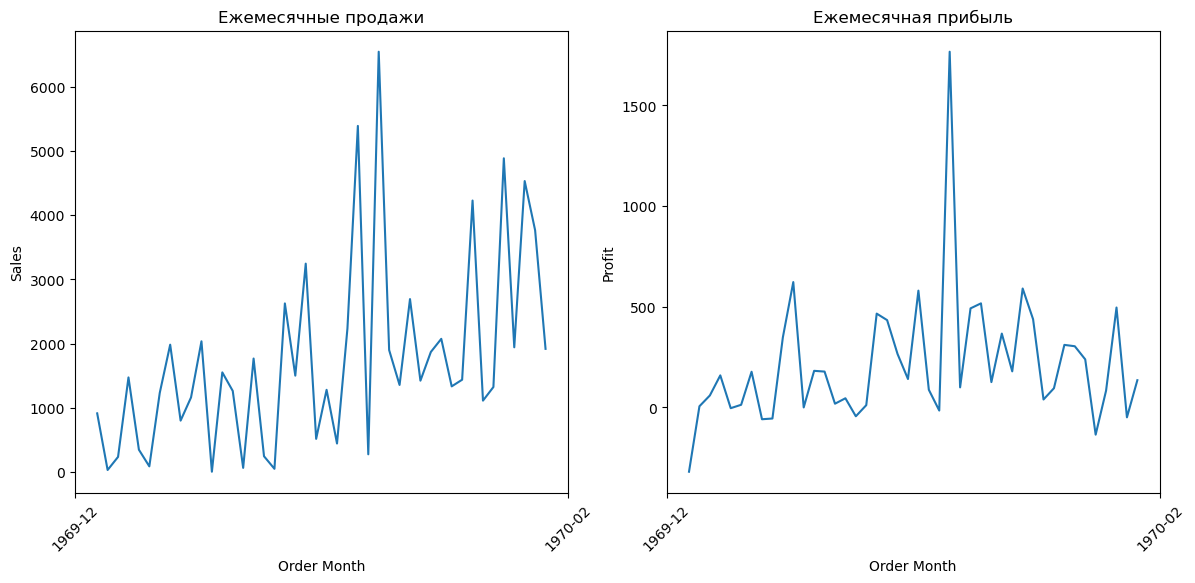

ADF-статистика: -1.8041194484302734
p-значение: 0.37841842831246986
Временной ряд продаж не является стационарным.


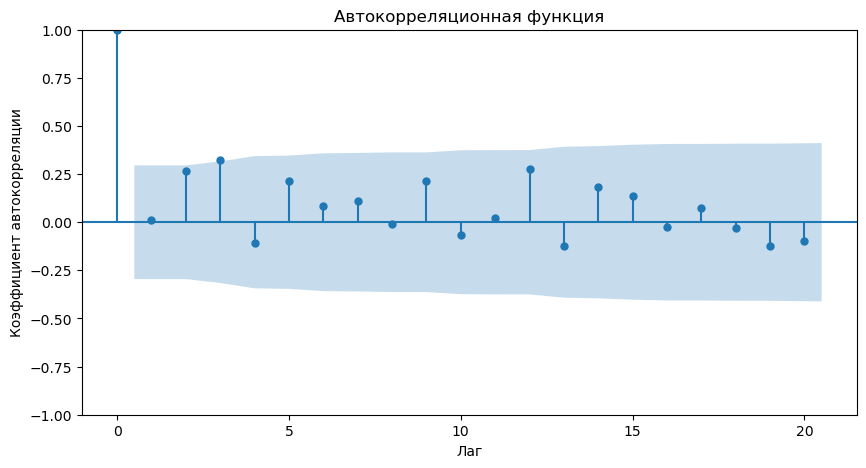


Гипотеза H2: Сезонность продаж по дате заказа.
Интерпретация: Продажи могут быть сезонными, и их объем может меняться в зависимости от времени года.

Результаты теста Дики-Фуллера:
 Временной ряд продаж не является стационарным (p-value >= 0.05).

Результаты анализа автокорреляции:
 Найдены значимые лаги функции автокорреляции, указывающие на наличие автокорреляции и возможную сезонность:
 Лаг: 0
 Лаг: 3


In [100]:
# Гипотеза 2: Сезонность продаж

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf

# Новый столбик для месяца заказа
processed_dataframe['Order Month'] = processed_dataframe['Order Date'].dt.to_period('M')

# Агрегируем данные по месяцам
monthly_sales = processed_dataframe.groupby('Order Month').agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()

# Преобразуем столбец 'Order Month' в строку из-за ошибки
monthly_sales['Order Month'] = monthly_sales['Order Month'].astype(str)

# Визуализируем продажи и прибыль по месяцам
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x='Order Month', y='Sales', data=monthly_sales, ax=ax1)
ax1.set_title('Ежемесячные продажи')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.lineplot(x='Order Month', y='Profit', data=monthly_sales, ax=ax2)
ax2.set_title('Ежемесячная прибыль')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.show()

# Проверяем стационарность временного ряда продаж с помощью теста Дики-Фуллера
adf_test_result = adfuller(monthly_sales['Sales'])
print(f"ADF-статистика: {adf_test_result[0]}")
print(f"p-значение: {adf_test_result[1]}")

# Если p-значение меньше 0.05, то ряд стационарен
if adf_test_result[1] < 0.05:
    print("Временной ряд продаж является стационарным.")
else:
    print("Временной ряд продаж не является стационарным.")

# Визуализируем автокорреляционную функцию с помощью функции plot_acf
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(monthly_sales['Sales'], lags=20, alpha=0.05, ax=ax)
ax.set_xlabel('Лаг')
ax.set_ylabel('Коэффициент автокорреляции')
ax.set_title('Автокорреляционная функция')
plt.show()

# Определить значимые лаги функции автокорреляции
lags_with_significant_correlation = []
confidence_interval = 1.96 / np.sqrt(len(monthly_sales['Sales']))
acf_values = acf(monthly_sales['Sales'], nlags=20)

lags_with_significant_correlation = []
for i, v in enumerate(acf_values):
    if v > confidence_interval:
        lags_with_significant_correlation.append(i)

# Интерпретация результатов
print("\nГипотеза H2: Сезонность продаж по дате заказа.")
print("Интерпретация: Продажи могут быть сезонными, и их объем может меняться в зависимости от времени года.")

print("\nРезультаты теста Дики-Фуллера:")
if adf_test_result[1] < 0.05:
    print(" Временной ряд продаж является стационарным (p-value < 0.05).")
else:
    print(" Временной ряд продаж не является стационарным (p-value >= 0.05).")

print("\nРезультаты анализа автокорреляции:")
if lags_with_significant_correlation:
    print(" Найдены значимые лаги функции автокорреляции, указывающие на наличие автокорреляции и возможную сезонность:")
    for lag in lags_with_significant_correlation:
        print(f" Лаг: {lag}")
else:
    print(" Значимые лаги функции автокорреляции не найдены, что указывает на отсутствие автокорреляции и сезонности.")


In [ ]:
# Гипотеза 3: Сравнение продаж между сегментами клиентов

from scipy.stats import ttest_ind, f_oneway

# Выбираем данные для каждого сегмента
corporate_sales = processed_dataframe[processed_dataframe['Segment'] == 'Corporate']['Sales']
consumer_sales = processed_dataframe[processed_dataframe['Segment'] == 'Consumer']['Sales']
home_office_sales = processed_dataframe[processed_dataframe['Segment'] == 'Home Office']['Sales']

# Выполняем однофакторный дисперсионный анализ
fstat, pvalue = f_oneway(corporate_sales, consumer_sales, home_office_sales)

# Выводим результаты теста
print(f"Результаты однофакторного дисперсионного анализа:")
print(f"F-статистика: {fstat:.2f}")
print(f"p-value: {pvalue:.3f}")

# Интерпретируем результаты теста
if pvalue < 0.05:
    print("Различия между сегментами являются статистически значимыми.")
else:
    print("Различия между сегментами не являются статистически значимыми.")

# Построение графиков
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Столбчатая диаграмма total sales по сегментам
segment_totals = [corporate_sales.sum(), consumer_sales.sum(), home_office_sales.sum()]
segments = ['Corporate', 'Consumer', 'Home Office']
ax1.bar(segments, segment_totals)
ax1.set_title('Total Sales по сегментам')
ax1.set_xlabel('Сегменты')
ax1.set_ylabel('Total Sales')

# Гистограмма медианной цены продаж по сегментам
corporate_median_price = (corporate_sales / processed_dataframe[processed_dataframe['Segment'] == 'Corporate']['Quantity']).median()
consumer_median_price = (consumer_sales / processed_dataframe[processed_dataframe['Segment'] == 'Consumer']['Quantity']).median()
home_office_median_price = (home_office_sales / processed_dataframe[processed_dataframe['Segment'] == 'Home Office']['Quantity']).median()

median_prices = [corporate_median_price, consumer_median_price, home_office_median_price]
ax2.bar(segments, median_prices)
ax2.set_title('Медианная цена продаж по сегментам')
ax2.set_xlabel('Сегменты')
ax2.set_ylabel('Медианная цена')

# Круговая диаграмма продаж по сегментам в процентах
total_sales = processed_dataframe['Sales'].sum()
segment_percentages = [sales / total_sales * 100 for sales in segment_totals]
ax3.pie(segment_percentages, labels=segments, autopct='%1.1f%%')
ax3.set_title('Продажи по сегментам')

plt.show()


          count      mean       std  min  25%  50%  75%  max
Returned                                                    
False     189.0  3.920635  1.597554  0.0  3.0  4.0  5.0  7.0
True       13.0  3.769231  2.047513  0.0  2.0  4.0  5.0  7.0


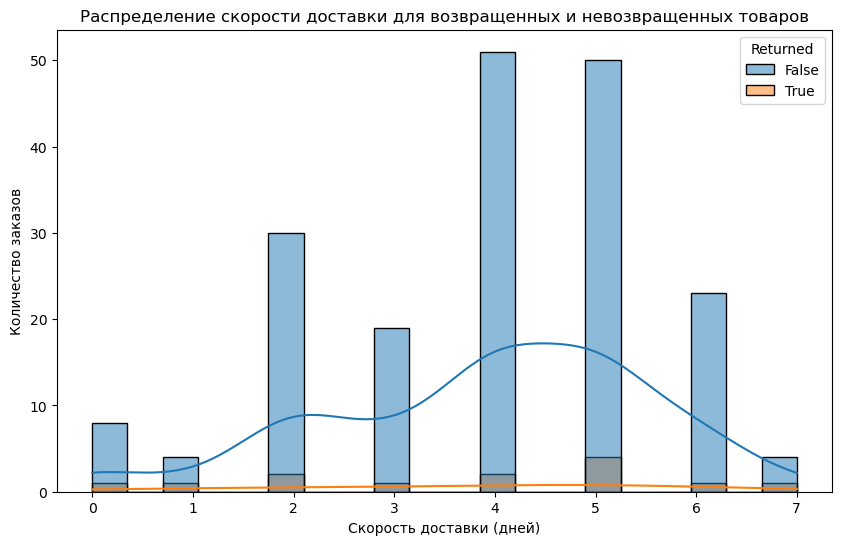

t-статистика: -0.3243349276823648
p-значение: 0.7460234350750823

Гипотеза H4: Эффект скорости доставки на возврат товаров.
  Результаты t-теста не указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value >= 0.05).
  Это может свидетельствовать о том, что скорость доставки не оказывает значительного влияния на возврат товаров.


In [164]:
#Гипотеза 4: Эффект скорости доставки на возврат товаров

file_path

if 'Orders' not in dataframes:
    orders = pd.read_excel(file_path, sheet_name='Orders')
else:
    orders = processed_dataframe

if 'Returns' not in dataframes:
    returns = pd.read_excel(file_path, sheet_name='Returns')
else:
    returns = dataframes['Returns']

# Вычисление скорости доставки (разница между датой отправки и датой заказа)
orders['Delivery Speed'] = (orders['Ship Date'] - orders['Order Date']).dt.days

# Добавление столбца 'Returned' в датафрейм orders, со значениями True или False
orders['Returned'] = orders['Order ID'].isin(returns['Order ID'])

# Агрегирование данных по скорости доставки и статусу возврата
delivery_speed_by_return_status = orders.groupby('Returned')['Delivery Speed'].describe()

print(delivery_speed_by_return_status)

# Визуализация распределения скорости доставки для возвращенных и невозвращенных товаров
plt.figure(figsize=(10, 6))
sns.histplot(data=orders, x='Delivery Speed', hue='Returned', kde=True, bins=20)
plt.xlabel('Скорость доставки (дней)')
plt.ylabel('Количество заказов')
plt.title('Распределение скорости доставки для возвращенных и невозвращенных товаров')
plt.show()

# Выполнение t-теста для сравнения средней скорости доставки для возвращенных и невозвращенных товаров
from scipy.stats import ttest_ind

returned_delivery_speed = orders[orders['Returned']]['Delivery Speed']
not_returned_delivery_speed = orders[~orders['Returned']]['Delivery Speed']
t_statistic, p_value = ttest_ind(returned_delivery_speed, not_returned_delivery_speed)

print(f"t-статистика: {t_statistic}")
print(f"p-значение: {p_value}")

# Интерпретация результатов
print("\nГипотеза H4: Эффект скорости доставки на возврат товаров.")
if p_value < 0.05:
    print("  Результаты t-теста указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value < 0.05).")
    print("  Это может свидетельствовать о том, что скорость доставки влияет на возврат товаров.")
else:
    print("  Результаты t-теста не указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value >= 0.05).")
    print("  Это может свидетельствовать о том, что скорость доставки не оказывает значительного влияния на возврат товаров.")

In [ ]:
# Гипотеза 5. Продажи и прибыль по географическим регионам

from scipy.stats import f_oneway

# Выбираем данные для каждого региона
regions = processed_dataframe['Region'].unique()
region_sales = [processed_dataframe[processed_dataframe['Region'] == region]['Sales'] for region in regions]

# Выполняем однофакторный дисперсионный анализ
fstat, pvalue = f_oneway(*region_sales)

# Выводим результаты теста
print(f"Результаты однофакторного дисперсионного анализа:")
print(f"F-статистика: {fstat:.2f}")
print(f"p-value: {pvalue:.3f}")

# Интерпретируем результаты теста
if pvalue < 0.05:
    print("Различия между регионами являются статистически значимыми.")
else:
    print("Различия между регионами не являются статистически значимыми.")

# Построение графиков
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Столбчатая диаграмма total sales по регионам
region_totals = [sales.sum() for sales in region_sales]
ax1.bar(regions, region_totals)
ax1.set_title('Total Sales по регионам')
ax1.set_xlabel('Регионы')
ax1.set_ylabel('Total Sales')

# Столбчатая диаграмма средней прибыли по регионам
region_profits = [processed_dataframe[processed_dataframe['Region'] == region]['Profit'].mean() for region in regions]
ax2.bar(regions, region_profits)
ax2.set_title('Средняя прибыль по регионам')
ax2.set_xlabel('Регионы')
ax2.set_ylabel('Средняя прибыль')

# Круговая диаграмма продаж по регионам в процентах
total_sales = processed_dataframe['Sales'].sum()
regions_percentages = [sales / total_sales * 100 for sales in region_totals]
ax3.pie(regions_percentages, labels=regions, autopct='%1.1f%%')
ax3.set_title('Продажи по регионам')

plt.show()

Результаты однофакторного дисперсионного анализа:
F-статистика: 7.46
p-value: 0.000
Различия между подкатегориями являются статистически значимыми.


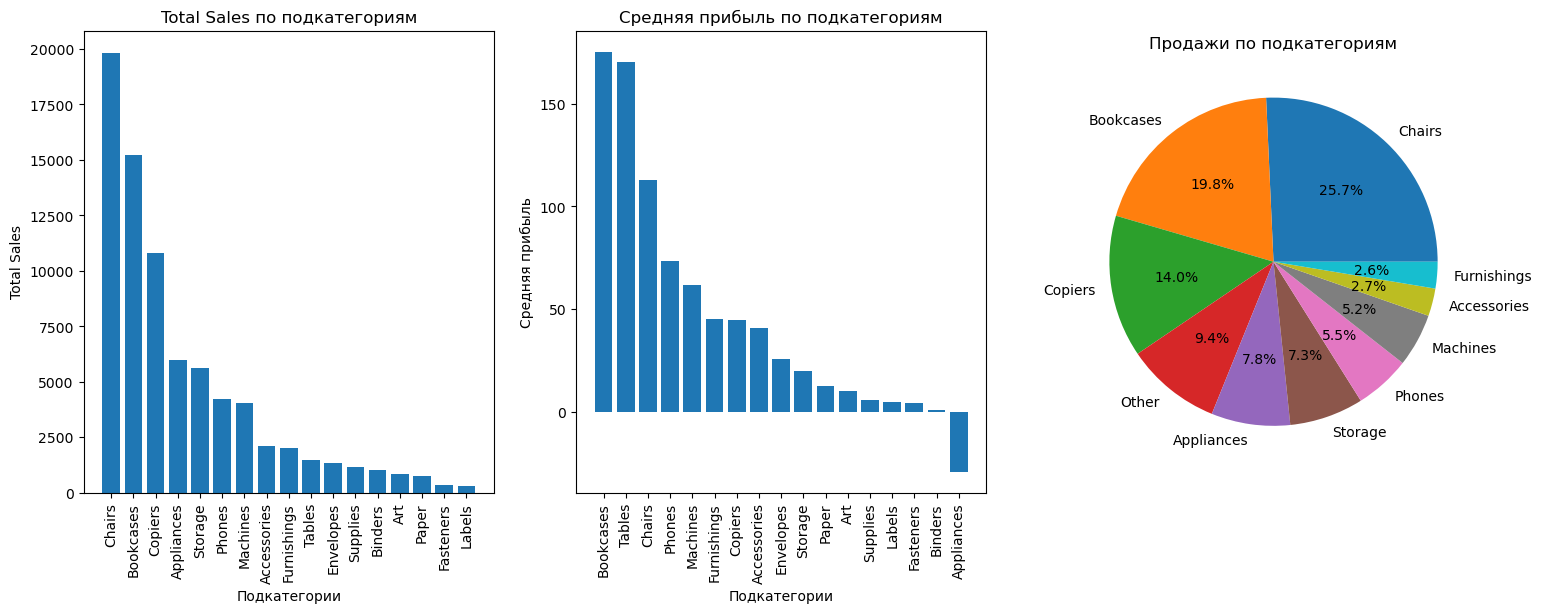

In [116]:
# Гипотеза 6: Влияние категории товара на продажи и прибыль

from scipy.stats import f_oneway

# Выбираем данные для каждой подкатегории
sub_categories = processed_dataframe['Sub-Category'].unique()
sub_category_sales = [processed_dataframe[processed_dataframe['Sub-Category'] == sub_category]['Sales'] for sub_category in sub_categories]

# Выполняем однофакторный дисперсионный анализ
fstat, pvalue = f_oneway(*sub_category_sales)

# Выводим результаты теста
print(f"Результаты однофакторного дисперсионного анализа:")
print(f"F-статистика: {fstat:.2f}")
print(f"p-value: {pvalue:.3f}")

# Интерпретируем результаты теста
if pvalue < 0.05:
    print("Различия между подкатегориями являются статистически значимыми.")
else:
    print("Различия между подкатегориями не являются статистически значимыми.")

# Отсортированные индексы для графиков ax1 и ax2
sorted_totals_idx = sorted(range(len(sub_category_totals)), key=lambda i: sub_category_totals[i], reverse=True)
sorted_profits_idx = sorted(range(len(sub_category_profits)), key=lambda i: sub_category_profits[i], reverse=True)

# Отсортированные значения для графиков ax1 и ax2
sorted_sub_categories_totals = [sub_categories[i] for i in sorted_totals_idx]
sorted_sub_category_totals = [sub_category_totals[i] for i in sorted_totals_idx]
sorted_sub_categories_profits = [sub_categories[i] for i in sorted_profits_idx]
sorted_sub_category_profits = [sub_category_profits[i] for i in sorted_profits_idx]

# Объединение подкатегорий с продажами меньше 2% в одну категорию "Other"
sub_category_percentages = [sales / total_sales * 100 for sales in sub_category_totals]
other_percentage = sum(percentage for percentage in sub_category_percentages if percentage < 2)
filtered_sub_categories = [sub_categories[i] for i, percentage in enumerate(sub_category_percentages) if percentage >= 2]
filtered_percentages = [percentage for percentage in sub_category_percentages if percentage >= 2]

# Добавление категории "Other"
filtered_sub_categories.append('Other')
filtered_percentages.append(other_percentage)

# Отсортированные индексы для круговой диаграммы
sorted_percentages_idx = sorted(range(len(filtered_percentages)), key=lambda i: filtered_percentages[i], reverse=True)

# Отсортированные значения для круговой диаграммы
sorted_filtered_sub_categories = [filtered_sub_categories[i] for i in sorted_percentages_idx]
sorted_filtered_percentages = [filtered_percentages[i] for i in sorted_percentages_idx]

# Построение графиков
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Столбчатая диаграмма total sales по подкатегориям
ax1.bar(sorted_sub_categories_totals, sorted_sub_category_totals)
ax1.set_title('Total Sales по подкатегориям')
ax1.set_xlabel('Подкатегории')
ax1.set_ylabel('Total Sales')
ax1.xaxis.set_major_locator(ticker.FixedLocator(range(len(sorted_sub_categories_totals))))
ax1.set_xticklabels(sorted_sub_categories_totals, rotation=90)

# Столбчатая диаграмма средней прибыли по подкатегориям
ax2.bar(sorted_sub_categories_profits, sorted_sub_category_profits)
ax2.set_title('Средняя прибыль по подкатегориям')
ax2.set_xlabel('Подкатегории')
ax2.set_ylabel('Средняя прибыль')
ax2.xaxis.set_major_locator(ticker.FixedLocator(range(len(sorted_sub_categories_profits))))
ax2.set_xticklabels(sorted_sub_categories_profits, rotation=90)

# Круговая диаграмма продаж по подкатегориям в процентах
ax3.pie(sorted_filtered_percentages, labels=sorted_filtered_sub_categories, autopct='%1.1f%%')
ax3.set_title('Продажи по подкатегориям')

plt.show()

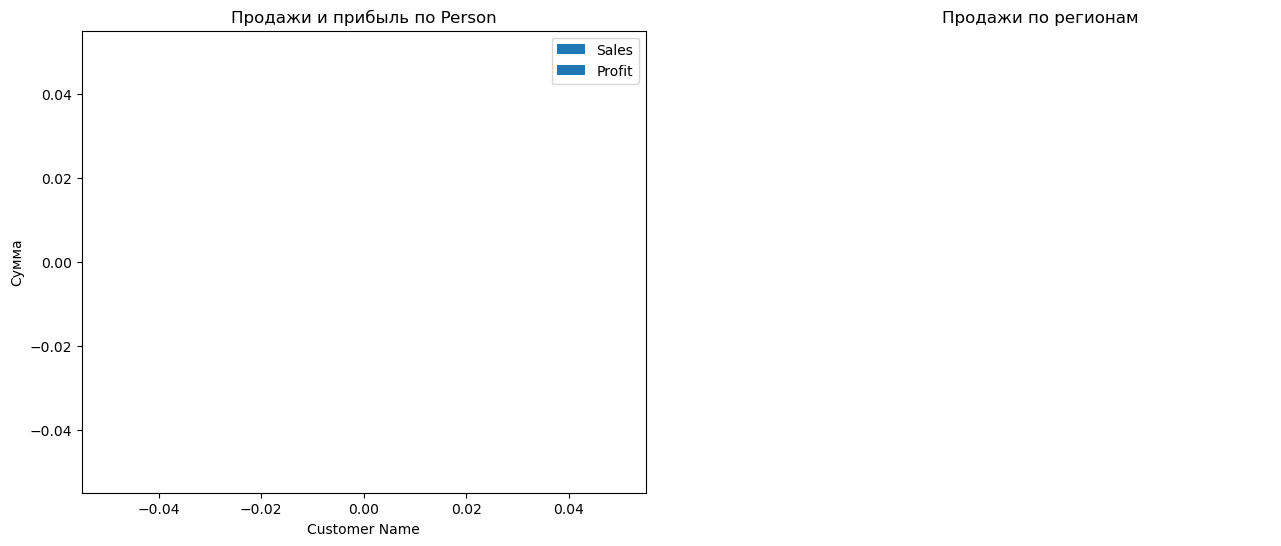

In [176]:
# # Гипотеза 7: Влияние некоторых персон и регионов на продажи и прибыль.

# file_path = 'C:/Users/knstrock/Desktop/JOB/ASBIS/Sample - APAC Superstore.xls'

# # Загрузка данных из листа "People", если они еще не были загружены
# if 'People' not in processed_dataframe:
#     people = pd.read_excel(file_path, sheet_name='People')
# else:
#     people = processed_dataframe['People']

# # Изменение имени колонки 'Person' на 'Customer Name' в датафрейме people
# people = people.rename(columns={'Person': 'Customer Name'})

# # Объединение данных из основного датафрейма с данными из листа "People" по 'Customer Name'
# merged_dataframe = processed_dataframe.merge(people, on='Customer Name')

# # Группировка данных по 'Customer Name'
# grouped_by_person = merged_dataframe.groupby('Customer Name').agg({'Sales': 'sum', 'Profit': 'sum'})

# # Группировка данных по 'Region'
# grouped_by_region = merged_dataframe.groupby('Region_x').agg({'Sales': 'sum', 'Profit': 'sum'})

# # Визуализация результатов
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # Столбчатая диаграмма для 'Customer Name'
# ax1.bar(grouped_by_person.index, grouped_by_person['Sales'], label='Sales')
# ax1.bar(grouped_by_person.index, grouped_by_person['Profit'], label='Profit')
# ax1.set_title('Продажи и прибыль по Person')
# ax1.set_xlabel('Customer Name')
# ax1.set_ylabel('Сумма')
# ax1.legend()

# # Круговая диаграмма для 'Region'
# ax2.pie(grouped_by_region['Sales'], labels=grouped_by_region.index, autopct='%1.1f%%')
# ax2.set_title('Продажи по регионам')

# plt.show()

Гипотеза H8: Возвраты и способ доставки.
Chi2: 0.430, p-value: 0.934
Результаты chi-square test не указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value >= 0.05).
Это может свидетельствовать о том, что скорость доставки не оказывает значительного влияния на возврат товаров.


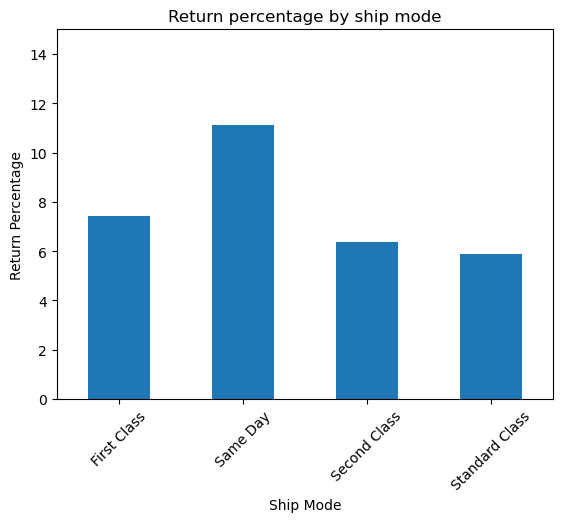

In [188]:
# Гипотеза 8: Возвраты и способ доставки

from scipy.stats import chi2_contingency

print("Гипотеза H8: Возвраты и способ доставки.")

# Создание таблицы сопряженности для количества возвратов и способа доставки
contingency_table = return_by_shipmode.T.iloc[:-1]

# Выполнение chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi2: {chi2:.3f}, p-value: {p_value:.3f}")

# Вывод на основе p-value
if p_value >= 0.05:
    print("Результаты chi-square test не указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value >= 0.05).")
    print("Это может свидетельствовать о том, что скорость доставки не оказывает значительного влияния на возврат товаров.")
else:
    print("Результаты chi-square test указывают на значимую разницу в скорости доставки для возвращенных и невозвращенных товаров (p-value < 0.05).")
    print("Это может свидетельствовать о том, что скорость доставки оказывает значительное влияние на возврат товаров.")

# Построение графика для визуализации процента возвратов по способам доставки
return_by_shipmode['Return Percentage'].plot(kind='bar', ylabel='Return Percentage', title='Return percentage by ship mode', ylim=(0, 15))
plt.xticks(rotation=45)
plt.show()

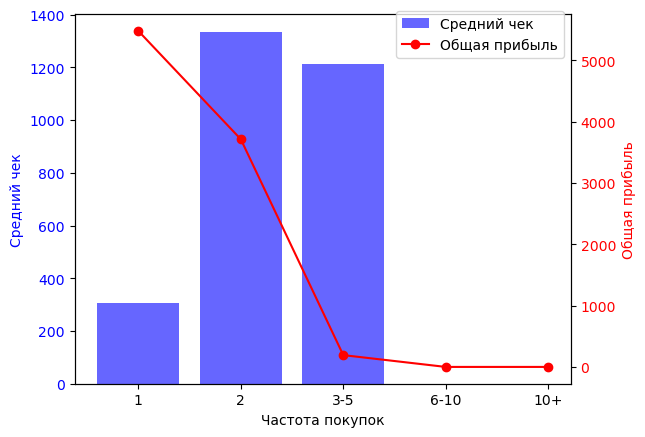

Для среднего чека: F-статистика: 26.719, p-значение: 0.000
Для общей прибыли: F-статистика: 6.286, p-значение: 0.002


In [191]:
# Гипотеза 9: Частота повторных покупок

# Подготовка данных для графика
bar_plot_data = orders_by_customer.groupby('Order Frequency').agg({'Sales': 'mean', 'Profit': 'sum'}).reset_index()

# Создание графика с двумя осями Y
fig, ax1 = plt.subplots()

# Построение графика среднего чека
ax1.bar(bar_plot_data['Order Frequency'], bar_plot_data['Sales'], alpha=0.6, color='blue', label='Средний чек')
ax1.set_xlabel('Частота покупок')
ax1.set_ylabel('Средний чек', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Создание второй оси Y
ax2 = ax1.twinx()

# Построение графика общей прибыли
ax2.plot(bar_plot_data['Order Frequency'], bar_plot_data['Profit'], color='red', marker='o', label='Общая прибыль')
ax2.set_ylabel('Общая прибыль', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Отображение легенды
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Отображение графика
plt.show()

# Вывод результатов тестирования значимости с тремя знаками после запятой
print(f"Для среднего чека: F-статистика: {f_stat_sales:.3f}, p-значение: {p_value_sales:.3f}")
print(f"Для общей прибыли: F-статистика: {f_stat_profit:.3f}, p-значение: {p_value_profit:.3f}")

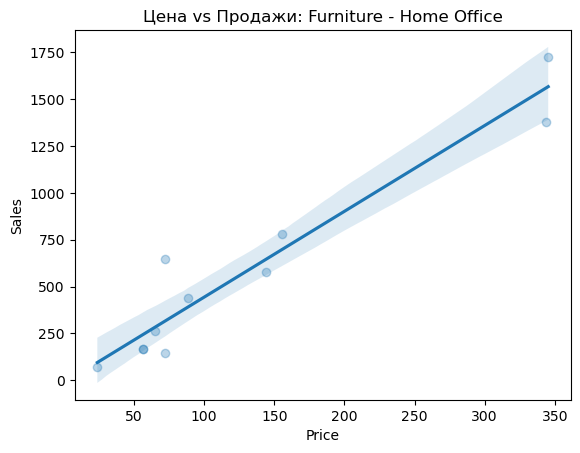

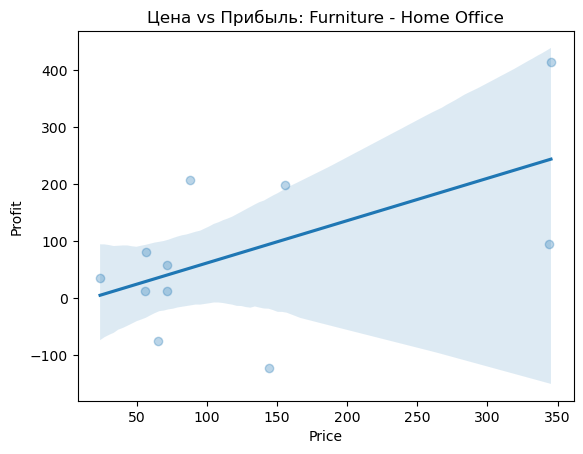

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Furniture, Сегмент: Home Office)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена не оказывает значимого влияния на прибыль (p-value >= 0.05).


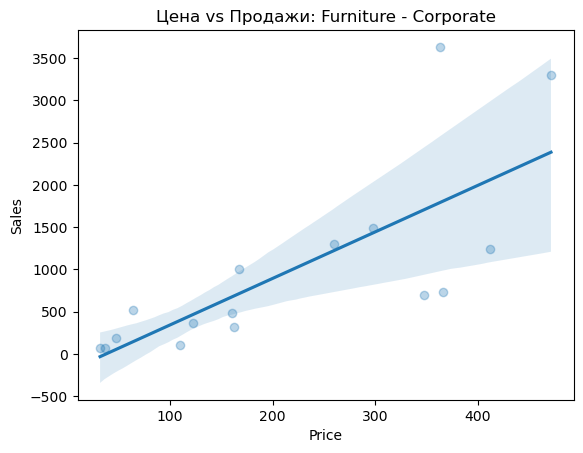

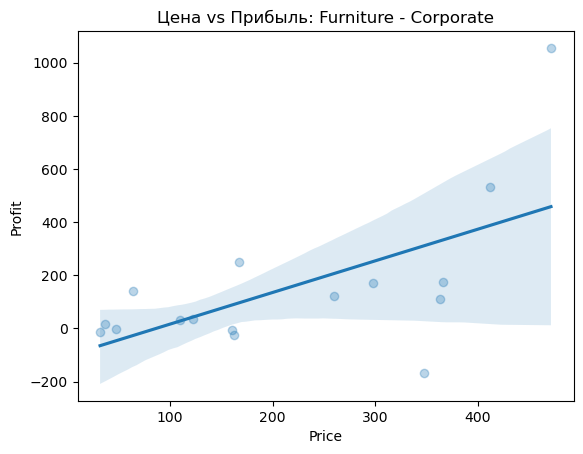

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Furniture, Сегмент: Corporate)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).


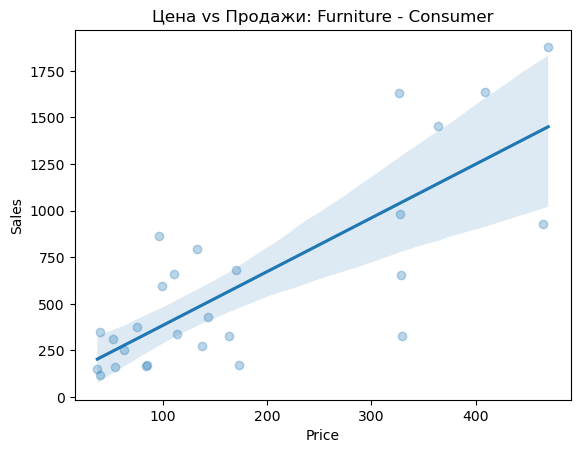

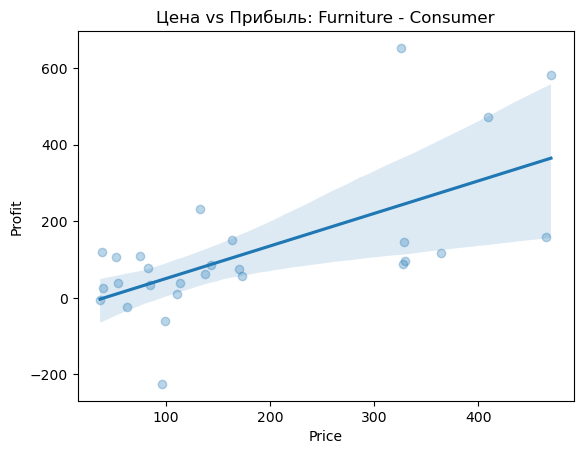

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Furniture, Сегмент: Consumer)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).


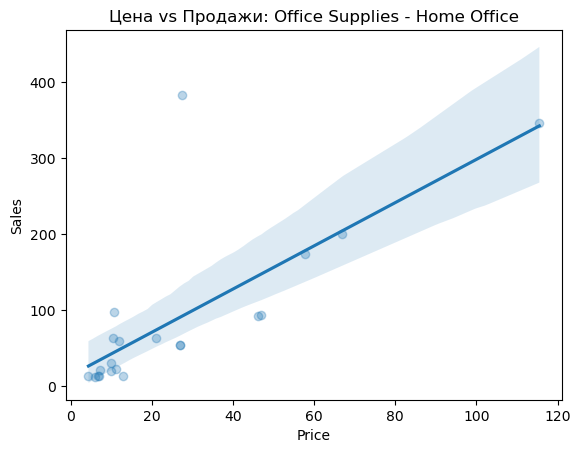

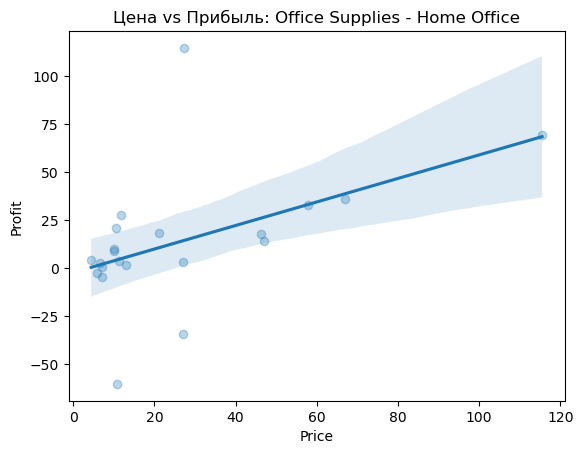

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Office Supplies, Сегмент: Home Office)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).


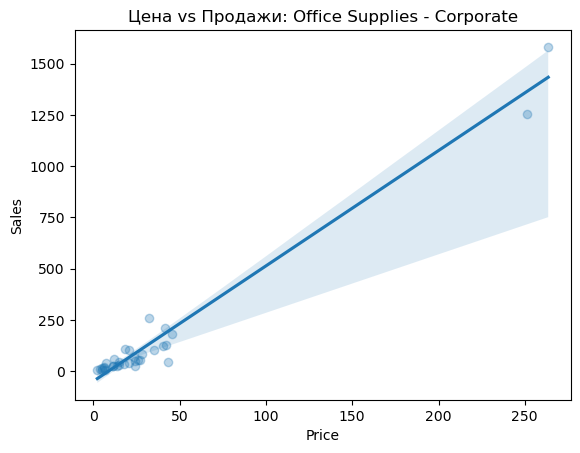

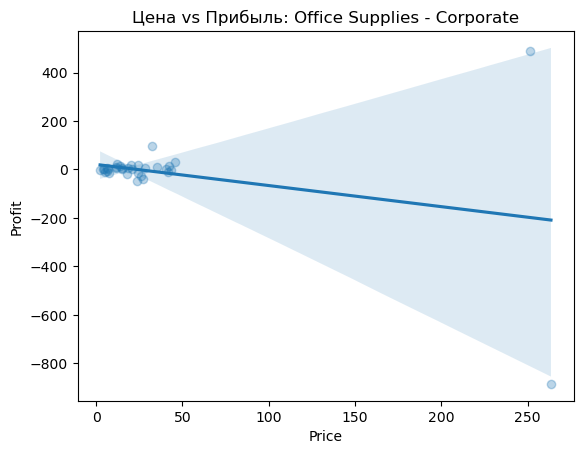

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Office Supplies, Сегмент: Corporate)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена не оказывает значимого влияния на прибыль (p-value >= 0.05).


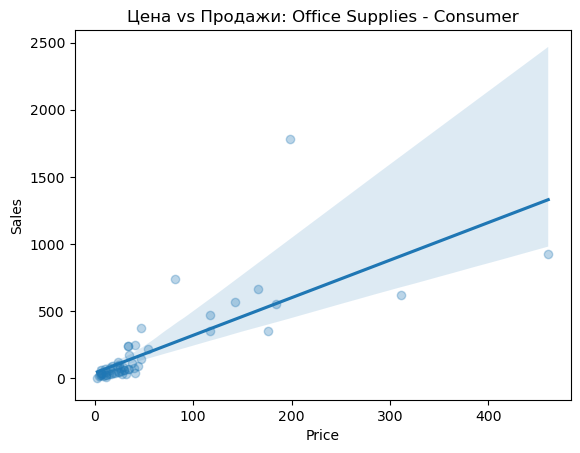

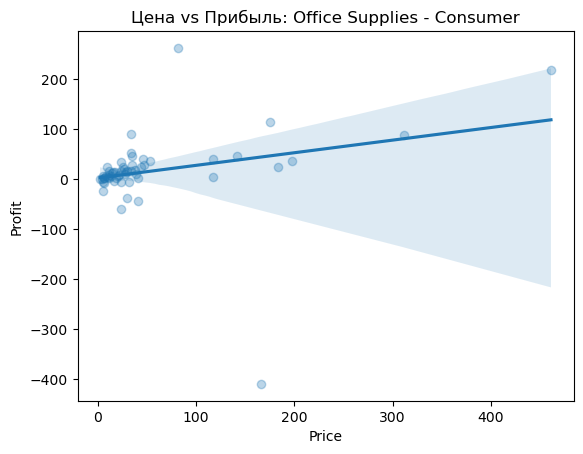

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Office Supplies, Сегмент: Consumer)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).


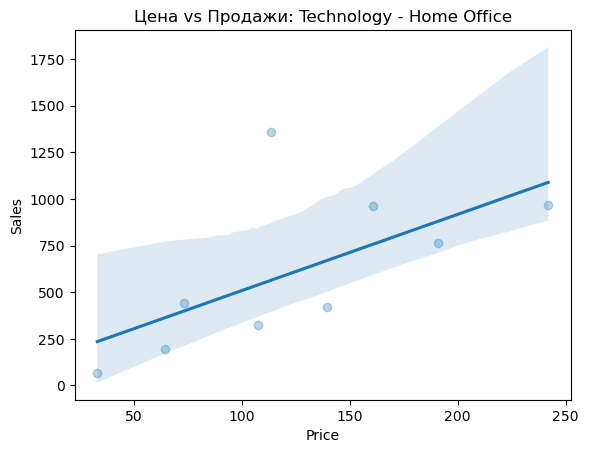

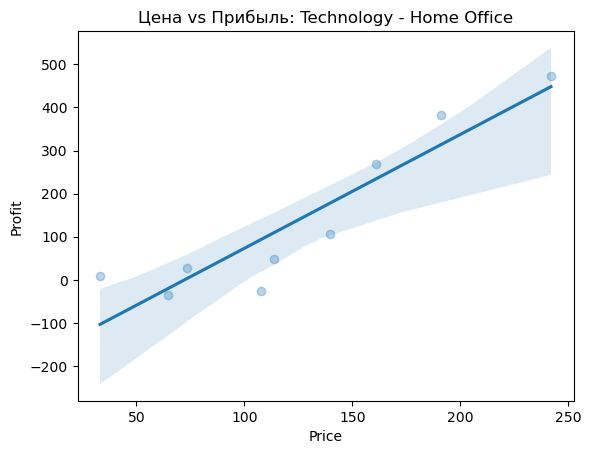

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Technology, Сегмент: Home Office)
  - Цена не оказывает значимого влияния на продажи (p-value >= 0.05).
  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).


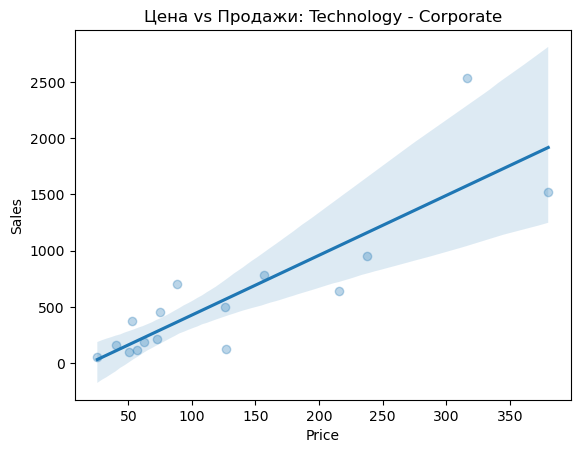

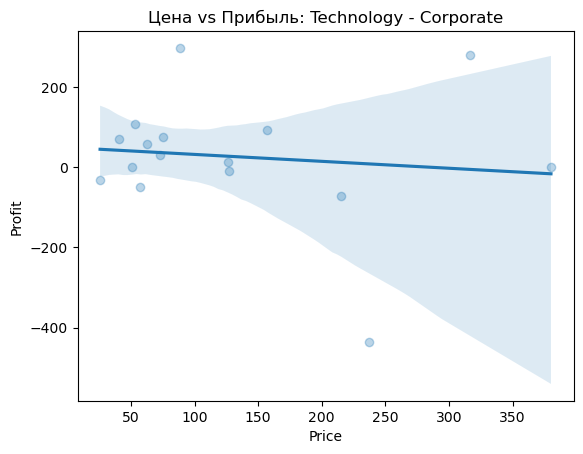

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Technology, Сегмент: Corporate)
  - Цена оказывает значимое влияние на продажи (p-value < 0.05).
  - Цена не оказывает значимого влияния на прибыль (p-value >= 0.05).


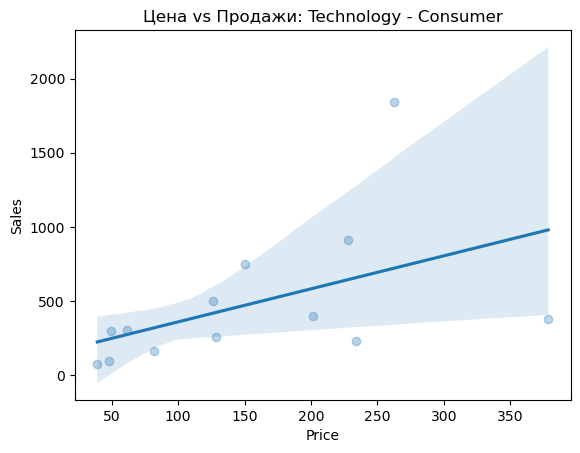

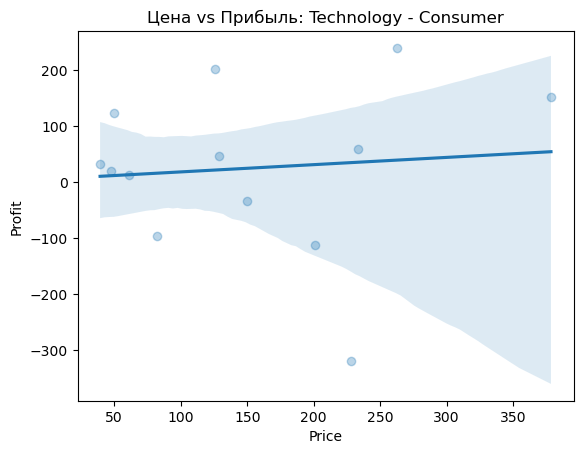

Гипотеза H21: Влияние цены на продажи и прибыль (Категория: Technology, Сегмент: Consumer)
  - Цена не оказывает значимого влияния на продажи (p-value >= 0.05).
  - Цена не оказывает значимого влияния на прибыль (p-value >= 0.05).


In [195]:
# Гипотеза 10: Влияние цены на продажи и прибыль

# Цикл по категориям товаров и сегментам клиентов
for category in categories:
    for segment in segments:
        sub_data = processed_dataframe[(processed_dataframe['Category'] == category) & (processed_dataframe['Segment'] == segment)]
        
        # Построение графика цены vs продажи с линией тренда
        plt.figure()
        sns.regplot(data=sub_data, x='Price', y='Sales', scatter_kws={'alpha': 0.3})
        plt.title(f"Цена vs Продажи: {category} - {segment}")
        plt.show()
        
        # Построение графика цены vs прибыли с линией тренда
        plt.figure()
        sns.regplot(data=sub_data, x='Price', y='Profit', scatter_kws={'alpha': 0.3})
        plt.title(f"Цена vs Прибыль: {category} - {segment}")
        plt.show()
        
        # Оценка значимости коэффициентов линейной регрессии
        X = sub_data['Price']
        y_sales = sub_data['Sales']
        y_profit = sub_data['Profit']
        X = sm.add_constant(X)
        
        model_sales = sm.OLS(y_sales, X).fit()
        model_profit = sm.OLS(y_profit, X).fit()
        
#         print(f"Категория: {category}, Сегмент: {segment}")
#         print("Sales: ", model_sales.summary())
#         print("Profit: ", model_profit.summary())

        # Выводы
        print(f"Гипотеза H10: Влияние цены на продажи и прибыль (Категория: {category}, Сегмент: {segment})")
        sales_pvalue = model_sales.pvalues['Price']
        profit_pvalue = model_profit.pvalues['Price']
        
        if sales_pvalue < 0.05:
            print("  - Цена оказывает значимое влияние на продажи (p-value < 0.05).")
        else:
            print("  - Цена не оказывает значимого влияния на продажи (p-value >= 0.05).")
        
        if profit_pvalue < 0.05:
            print("  - Цена оказывает значимое влияние на прибыль (p-value < 0.05).")
        else:
            print("  - Цена не оказывает значимого влияния на прибыль (p-value >= 0.05).")
